In [145]:
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm
import copy
from tictactoe_env import *

# Часть первая: крестики-нолики при помощи Q-обучения

In [146]:
class AgentRandom:
    def explotation_action(self, state, actions=None, env=None):
        return env.getEmptySpaces()[np.random.randint(np.sum(np.array(list(state)) == '1') if not actions else actions)]

def cacucate_winrates(env, agent_1, agent_2, games=10000,prt=False):
    crosses_wins = 0
    zeros_wins = 0
    for episode in tqdm(range(games)):
        done = False
        env.reset()
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                action = agent_1.explotation_action(s, len(actions), env=env)
            else:
                action = agent_2.explotation_action(''.join([str(2 - int(n)) for n in s]), len(actions), env=env)
            _, reward, done, _ = env.step(action)

        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            zeros_wins += 1      
    crosses_winrate = crosses_wins / games
    zeros_winrate = zeros_wins / games
    if prt:
        print("Winrate agent(cross): ", crosses_winrate)
        print("Winrate agent(zeros): ", zeros_winrate)
    return crosses_winrate, zeros_winrate

In [147]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                    AgentRandom(), 
                                                    AgentRandom(),
                                                    games=1000,
                                                  )

100%|██████████| 1000/1000 [00:00<00:00, 2345.28it/s]


In [4]:
print("Cross winrate: ", crosses_winrate)
print("Zeros winrate: ", zeros_winrate)

Cross winrate:  0.571
Zeros winrate:  0.285


### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Для агента конкурентная среда (как минимум против сслучайного агента) выглядит стохастической, при этом вариативность огромна, поэтому сделаем предположение что нужно много exploration.

In [14]:
class AgentQ():
    def __init__(self, alpha=0.1, gamma=1.):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
             
    def get_Q(self, state, n_actions=None):
        if state not in self.Q:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            self.Q[state] = np.ones(n_actions) * 0.01
        return self.Q[state]       


    def get_maxQ(self, state):
        return np.max(self.get_Q(state))
    
    
    def update(self, state, n_action, reward, next_state):
        Q = self.get_Q(state)[n_action]
        V = self.get_maxQ(next_state) if next_state else 0
        self.Q[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

        
    def get_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.explotation_action_(state, n_actions)
        else:
            if n_actions is None:
                n_actions = np.sum(np.array(list(state)) == '1')
            return np.random.randint(n_actions)
        

    def explotation_action_(self, state, n_actions=None, env=None):
        return np.argmax(self.get_Q(state, n_actions))
    

    def explotation_action(self, state, n_actions=None, env=None):
        return env.getEmptySpaces()[np.argmax(self.get_Q(state, n_actions))]

In [15]:
def train(env, 
             agent_to_train, agent_opponent_for_validation,
             epsilon_start=0.5, epsilon_min= 0.1 , epsilon_decay=0.999,
             train_episodes=100000, eval_episodes = 1000, eval_period = 10000):
    crosses_winrates = []
    zeros_winrates = []
    epsilon = epsilon_start

    for i in tqdm(range(train_episodes)):
        epsilon = max(epsilon*epsilon_decay, epsilon_min) 
        if i % eval_period == 0:
            crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_to_train, agent_opponent_for_validation, games=eval_episodes)
            crosses_winrates.append((i, crosses_winrate))
            crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_opponent_for_validation, agent_to_train, games=eval_episodes)
            zeros_winrates.append((i, zeros_winrate))
        done = False
        env.reset()
        prev_state, prev_actions = env.getHash(), env.getEmptySpaces()
        prev_action = agent_to_train.get_action(prev_state, epsilon, len(prev_actions))
        observation, reward, done, _ = env.step(prev_actions[prev_action])
        cur_state, cur_actions = observation[0], observation[1]
        curTurn = env.curTurn
        cur_state = ''.join([str(2 - int(n)) for n in cur_state])
        while not done:
            cur_action = agent_to_train.get_action(cur_state, epsilon, len(cur_actions))
            observation, reward, done, _ = env.step(cur_actions[cur_action])
            if done: 
                agent_to_train.update(prev_state, prev_action, -reward * curTurn, None)
                agent_to_train.update(cur_state, cur_action, reward * curTurn, None)
                break
            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = ''.join([str(2 - int(n)) for n in next_state])  
            agent_to_train.update(prev_state, prev_action, reward, next_state)
            prev_state, prev_actions = cur_state, cur_actions
            cur_state, cur_actions = next_state, observation[1]
            prev_action = cur_action
    return crosses_winrates, zeros_winrates

In [16]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_q = AgentQ(alpha = 0.1, gamma = 1)
agent_r = AgentRandom()
crosses_winrates, zeros_winrates = train(env, 
        agent_q, agent_r,
        epsilon_start=0.7, epsilon_min= 0.05 , epsilon_decay=0.999,
        train_episodes=100000, eval_period = 5000, eval_episodes = 1000)

100%|██████████| 100000/100000 [01:03<00:00, 1585.41it/s]


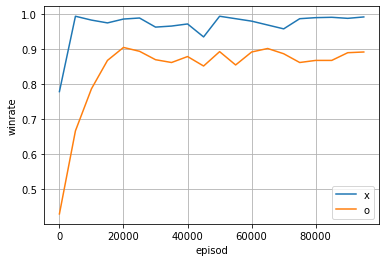

In [33]:
plt.plot([x[0] for x in crosses_winrates], [x[1] for x in crosses_winrates], label='x')
plt.plot([x[0] for x in crosses_winrates], [x[1] for x in zeros_winrates], label='o')
plt.grid()
plt.xlabel("episods")
plt.ylabel("winrate")
plt.legend()

In [34]:
cacucate_winrates(env, agent_q, agent_r, 1000,True);

Winrate agent(cross):  0.988
Winrate agent(zeros):  0.0


In [35]:
cacucate_winrates(env, agent_r,agent_q, 1000,True);

Winrate agent(cross):  0.004
Winrate agent(zeros):  0.871


### Board 4x4

In [26]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
agent_q = AgentQ(alpha = 0.1, gamma = 1)
agent_r = AgentRandom()
crosses_winrates, zeros_winrates = train(env, 
        agent_q, agent_r,
        epsilon_start=0.5, epsilon_min= 0.05 , epsilon_decay=0.9,
        train_episodes=2000000, eval_period = 40000, eval_episodes = 1000)

100%|██████████| 2000000/2000000 [39:23<00:00, 846.30it/s]  


## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4. Реализуйте Double DQN и/или Dueling DQN.


### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [4]:
from dqn import *

In [63]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
dqn = DQN(env)
for episode in tqdm(range(1000)):
    dqn.run_episode(episode)
    dqn.validate_against_random_agent_with_winrate(500)

100%|██████████| 1000/1000 [07:04<00:00,  2.36it/s]


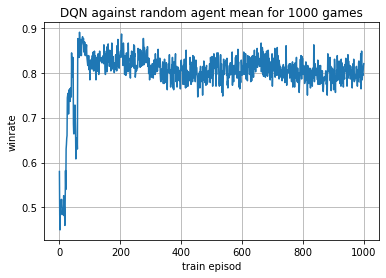

In [64]:
plt.plot(dqn.winrates)

plt.grid()
plt.xlabel("train episod")
plt.ylabel("winrate")

plt.title(f"DQN against random agent mean for 1000 games");

### DQN vs AgentRandom

In [29]:
%%time
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   dqn,
                                                   AgentRandom(), 
                                                   1000,
                                                  True)

Winrate agent(cross):  0.625
Winrate agent(zeros):  0.284
CPU times: user 859 ms, sys: 2.39 ms, total: 862 ms
Wall time: 861 ms


In [30]:
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   AgentRandom(), 
                                                   dqn,
                                                   1000,
                                                  True)

Winrate agent(cross):  0.671
Winrate agent(zeros):  0.288


### DQN vs AgentQ

In [31]:
%%time
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   dqn, 
                                                   agent_q,
                                                   1000,
                                                   True,)

Winrate agent(cross):  0.0
Winrate agent(zeros):  1.0
CPU times: user 653 ms, sys: 2.13 ms, total: 655 ms
Wall time: 655 ms


In [32]:
%%time
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   agent_q, 
                                                   dqn,
                                                   1000,
                                                   True,)

Winrate agent(cross):  1.0
Winrate agent(zeros):  0.0
CPU times: user 487 ms, sys: 2.08 ms, total: 489 ms
Wall time: 489 ms


In [143]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
dqn = DQN(env)
for episode in tqdm(range(1000)):
    dqn.run_episode(episode)
    dqn.validate_against_random_agent_with_winrate(500)

100%|██████████| 1000/1000 [00:20<00:00, 47.99it/s]


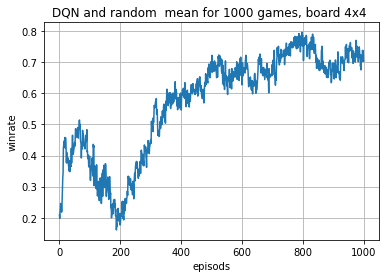

In [61]:
plt.plot(dqn.winrates)

plt.grid()
plt.xlabel("episods")
plt.ylabel("winrate")

plt.title(f"DQN and random  mean for 1000 games, board 4x4 ");

In [38]:
%%time
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   dqn, 
                                                   AgentRandom(),
                                                   1000,
                                                   True,)

Winrate agent(cross):  0.735
Winrate agent(zeros):  0.172
CPU times: user 1.34 s, sys: 4.31 ms, total: 1.35 s
Wall time: 1.35 s


In [39]:
%%time
crosses_winrate, zeros_winrate = cacucate_winrates(env,
                                                   AgentRandom(), 
                                                   dqn,
                                                   1000,
                                                   True,)

Winrate agent(cross):  0.189
Winrate agent(zeros):  0.349
CPU times: user 1.83 s, sys: 4.66 ms, total: 1.84 s
Wall time: 1.84 s


## Реализуйте Double DQN и/или Dueling DQN.

# Часть третья: расширим и углубим поиск

In [136]:
class MCTSNode():

    def __init__(self, env, board, parent_node=None):
        self.env = TicTacToe(env.n_rows, env.n_cols, env.n_win)
        self.env.board = copy.deepcopy(board)
        self.parent = parent_node
        self.children = []
        self.n = 0
        self.reward = 0
        self.actions = list(self.env.getEmptySpaces())
        self.env.isTerminal()

    def find_best_children(self, c_parameters=1):
        weights = list(map(lambda node: -node.reward / node.n + c_parameters * np.sqrt((np.log(self.n) / node.n)),
                           self.children)) 
        return np.argmax(weights)

        
    def rollout(self):
        rollout_env = TicTacToe(self.env.n_rows, self.env.n_cols, self.env.n_win)
        rollout_env.board = copy.deepcopy(self.env.board)
        rollout_env.curTurn = self.env.curTurn
#         rollout_env = copy.deepcopy(self.env)
        reward = rollout_env.isTerminal()
        gameOver = rollout_env.gameOver
        random_actions = list(np.random.permutation(rollout_env.getEmptySpaces()))
        while not gameOver:
            action = random_actions.pop()
            _, reward, gameOver, _ = rollout_env.step(action)
        return reward * self.env.curTurn


    def expand(self):
        action = self.actions.pop(0)
        next_env = copy.deepcopy(self.env.board)
        next_env[action[0], action[1]] = self.env.curTurn
        child_node = MCTSNode(self.env, next_env, parent_node=self)
        child_node.env.curTurn = -self.env.curTurn
        self.children.append(child_node)
        return child_node

    def backprop(self, reward):
        self.n += 1.
        self.reward += reward
        if self.parent:
            self.parent.backprop(-reward)

In [141]:
class AgentMCTS(object):
    def __init__(self, env, num_of_trees):
        self.env = env
        self.num_of_trees = num_of_trees
        
        
    def explotation_action(self, s, n_actions, env = None):
        board = np.array([float(n) for n in s]).reshape((self.env.n_rows, self.env.n_cols)) - 1
        root_node = MCTSNode(self.env, board)
        for _ in range(self.num_of_trees):            
            node = root_node
            while not node.env.gameOver:
                if len(node.actions) > 0:
                    node = node.expand()
                else:
                    node = node.children[node.find_best_children()]
            reward = node.rollout()
            node.backprop(reward)
        return env.getEmptySpaces()[root_node.find_best_children(c_parameters=0)]

### MCTS VS Random

In [48]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
agent_r = AgentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_m, agent_r,prt=True)

100%|██████████| 10000/10000 [19:48<00:00,  8.41it/s]

Winrate agent(cross):  0.9734
Winrate agent(zeros):  0.0001


In [56]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
agent_r = AgentRandom() 
crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_r, agent_m, prt=True)

100%|██████████| 10000/10000 [16:23<00:00, 10.17it/s]

Winrate agent(cross):  0.3773
Winrate agent(zeros):  0.5472


### MCTS VS Qlearn

In [58]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
agent_q = AgentQ(alpha = 0.1, gamma = 1)
crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_m, agent_q,prt=True)

100%|██████████| 10000/10000 [22:08<00:00,  7.53it/s]

Winrate agent(cross):  1.0
Winrate agent(zeros):  0.0


In [59]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
agent_q = AgentQ(alpha = 0.1, gamma = 1)
crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_q, agent_m,prt=True)

100%|██████████| 10000/10000 [14:18<00:00, 11.65it/s]

Winrate agent(cross):  0.3659
Winrate agent(zeros):  0.6341


### MCTS VS DQN

In [66]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
crosses_winrate, zeros_winrate = cacucate_winrates(env, agent_m, dqn,prt=True)

100%|██████████| 10000/10000 [18:11<00:00,  9.17it/s]

Winrate agent(cross):  1.0
Winrate agent(zeros):  0.0


In [67]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent_m = AgentMCTS(env, num_of_trees=100)
agent_q = AgentQ(alpha = 0.1, gamma = 1)
crosses_winrate, zeros_winrate = cacucate_winrates(env, dqn, agent_m,prt=True)

100%|██████████| 10000/10000 [13:24<00:00, 12.44it/s]

Winrate agent(cross):  0.6142
Winrate agent(zeros):  0.3729
